# Imports

In [1]:
import random

# from torch.utils.data import DataLoader
import matplotlib.animation as animate
import matplotlib.pyplot as plt
import numpy as np

# from sklearn.model_selection import cross_val_score
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as tf
from sklearn.datasets import fetch_lfw_people
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from torchvision import datasets

# Question 1

## Numpy Version of Code

In [2]:
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [3]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]
# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [4]:
# Split into a training set and a test set using a stratified k fold
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

In [5]:
# Center data
mean = np.mean(X_train, axis=0)
X_train -= mean
X_test -= mean
# Eigen-decomposition
U, S, V = np.linalg.svd(X_train, full_matrices=False)
components = V[:n_components]
print(U.shape)
print(S.shape)
print(V.shape)
eigenfaces = components.reshape((n_components, h, w))
# project into PCA subspace
X_transformed = np.dot(X_train, components.T)
print(X_transformed.shape)
X_test_transformed = np.dot(X_test, components.T)
print(X_test_transformed.shape)

(966, 966)
(966,)
(966, 1850)
(966, 150)
(322, 150)


In [ ]:
# Qualitative evaluation of the predictions using matplotlib
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

In [ ]:
explained_variance = (S**2) / (n_samples - 1)
total_var = explained_variance.sum()
explained_variance_ratio = explained_variance / total_var
ratio_cumsum = np.cumsum(explained_variance_ratio)
print(ratio_cumsum.shape)
eigenvalueCount = np.arange(n_components)
plt.plot(eigenvalueCount, ratio_cumsum[:n_components])
plt.title("Compactness")
plt.show()

In [ ]:
# build random forest
estimator = RandomForestClassifier(
    n_estimators=150, max_depth=15, max_features=150
)
estimator.fit(X_transformed, y_train)  # expects X as [n_samples, n_features]
predictions = estimator.predict(X_test_transformed)
correct = predictions == y_test
total_test = len(X_test_transformed)
# print("Gnd Truth:", y_test)
print("Total Testing", total_test)
print("Predictions", predictions)
print("Which Correct:", correct)
print("Total Correct:", np.sum(correct))
print("Accuracy:", np.sum(correct) / total_test)

In [ ]:
print(
    classification_report(
        y_test, predictions, target_names=target_names, zero_division=0.0
    )
)

## Pytorch Version of Code

In [ ]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
X = torch.from_numpy(X)
n_features = X.shape[1]
# the label to predict is the id of the person
y = lfw_people.target
y = torch.from_numpy(y)
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print("Total dataset size:")
print("n_samples: {n_samples}")
print("n_features: {n_features}")
print("n_classes: {n_classes}")

In [ ]:
# Split into a training set and a test set using a stratified k fold
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150
print(X_train.shape)
print(X_test.shape)

In [ ]:
# Center data
mean = torch.mean(X_train)
X_train -= mean
X_test -= mean

U, S, V = torch.linalg.svd(X_train, full_matrices=False)
components = V[:n_components]
# print(U.shape, S.shape, V.shape)
# print(components.T.shape)
eigenfaces = components.reshape((n_components, h, w))
# project into PCA subspace
X_transformed = torch.mm(X_train, components.T)
print(X_transformed.shape)
X_test_transformed = torch.mm(X_test, components.T)
print(X_test_transformed.shape)

In [ ]:
import matplotlib.pyplot as plt


# Qualitative evaluation of the predictions using matplotlib
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

In [ ]:
explained_variance = (S**2) / (n_samples - 1)
total_var = explained_variance.sum()
explained_variance_ratio = explained_variance / total_var
ratio_cumsum = torch.cumsum(explained_variance_ratio, 0)
print(ratio_cumsum.shape)
eigenvalueCount = torch.arange(n_components)
plt.plot(eigenvalueCount, ratio_cumsum[:n_components])
plt.title("Compactness")
plt.show()

In [ ]:
# build random forest
estimator = RandomForestClassifier(
    n_estimators=150, max_depth=15, max_features=150
)
estimator.fit(X_transformed, y_train)  # expects X as [n_samples, n_features]
predictions = torch.from_numpy(estimator.predict(X_test_transformed))
correct = predictions == y_test
total_test = len(X_test_transformed)
# print("Gnd Truth:", y_test)
print("Total Testing", total_test)
print("Predictions", predictions)
print("Which Correct:", correct)
print("Total Correct:", torch.sum(correct))
print("Accuracy:", torch.sum(correct) / total_test)

In [ ]:
print(
    classification_report(
        y_test, predictions, target_names=target_names, zero_division=0.0
    )
)

# Question 2

## Models

### Dense Only

In [ ]:
class DenseOnlyCNN(nn.Module):
    def __init__(self):
        super(DenseOnlyCNN, self).__init__()
        self.model = nn.Sequential(
            # nn.Flatten(),
            nn.Linear(1850, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(32, 7),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

### CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.unf = nn.Unflatten(1, (1, 50, 37))
        self.cnn_layers = nn.Sequential(
            # convolutional layer 1
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                padding=0,
                stride=1,
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # convolutional layer 2
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                padding=0,
                stride=1,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.linear_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2464, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1024, 7),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.unf(x)
        x = self.cnn_layers(x)
        x = self.linear_layers(x)
        return x

### CIFAR10 CNN

In [ ]:
class CIFAR_CNN(nn.Module):
    def __init__(self):
        super(CIFAR_CNN, self).__init__()
        self.unf = nn.Unflatten(1, (1, 50, 37))
        self.cnn_layers = nn.Sequential(
            # convolutional layer 1
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                padding=0,
                stride=1,
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # convolutional layer 2
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                padding=0,
                stride=1,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # convolutional layer 3
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                padding=0,
                stride=1,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.linear_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1024, 10),
        )

    def forward(self, x):
        x = self.unf(x)
        x = self.cnn_layers(x)
        # print(x.shape)
        x = self.linear_layers(x)
        return x

## Load Data

### LFW people

In [ ]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]
# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]


# print("Total dataset size:")
# print(f"n_samples: {n_samples}")
# print(f"n_features: {n_features}")
# print(f"n_classes: {n_classes}")
# print(h, w)

X = torch.from_numpy(X)
y = torch.from_numpy(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

train_set = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=128, shuffle=True
)

test_set = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=128, shuffle=True
)

i, (images, labels) = next(enumerate(train_loader))
print(X_train.shape)
print(images.shape)

### CIFAR10

In [ ]:
from torchvision.datasets import CIFAR10

train_dataset = CIFAR10(
    "./data/CIFAR10/Train",
    train=True,
    download=True,
    transform=tf.Compose(
        [
            tf.ToTensor(),
            tf.Normalize(
                mean=(0.49139968, 0.48215827, 0.44653124),
                std=(0.24703233, 0.24348505, 0.26158768),
            ),
        ]
    ),
)

test_dataset = CIFAR10(
    "./data/CIFAR10/Test",
    train=False,
    download=True,
    transform=tf.Compose(
        [
            tf.ToTensor(),
            tf.Normalize(
                mean=(0.49139968, 0.48215827, 0.44653124),
                std=(0.24703233, 0.24348505, 0.26158768),
            ),
        ]
    ),
)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=128, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=128, shuffle=True
)

# i, (images, labels) = next(enumerate(train_loader))

## Hyperparameters

### Dense Only

In [ ]:
LR = 1e-3
EPOCHS = 130
# wd = 0.01
loss_fn = nn.CrossEntropyLoss()
model = DenseOnlyCNN()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
DEVICE = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

### CNN

In [ ]:
LR = 1e-3
EPOCHS = 20
# wd = 0.01
loss_fn = nn.CrossEntropyLoss()
model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
DEVICE = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

### CIFAR10 CNN

In [ ]:
LR = 1e-3
EPOCHS = 30
# wd = 0.01
loss_fn = nn.CrossEntropyLoss()
model = CIFAR_CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
DEVICE = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

## Define Loss and Accuracy Functions

In [ ]:
def get_accuracy():
    test_acc = 0
    model.eval()

    with torch.no_grad():
        # Iterating over the training dataset in batches
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(DEVICE)
            y_true = labels.to(DEVICE)

            # Calculating outputs for the batch being iterated
            outputs = model(images)

            # Calculated prediction labels from models
            _, y_pred = torch.max(outputs.data, 1)

            # Comparing predicted and true labels
            test_acc += (y_pred == y_true).sum().item()

        print(f"Test set accuracy = {100 * test_acc / len(test_set)} %")
        return 100 * test_acc / len(test_set)


def get_loss():
    train_loss = 0

    # Iterating over the training dataset in batches
    model.train()

    for i, (images, labels) in enumerate(train_loader):
        # Extracting images and target labels for the batch being iterated
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Calculating the model output and the cross entropy loss
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Updating weights according to calculated loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Printing loss for each epoch
    train_loss_list.append(train_loss / len(train_loader))
    print(f"Training loss = {train_loss_list[-1]}")

## Loop for epochs

In [ ]:
train_loss_list = []
model = model.to(device=DEVICE)
best_acc = 0
best_epoch = -1
for epoch in range(EPOCHS):
    print(f"Epoch {epoch}/{EPOCHS} +++++++++++++++++")
    get_loss()
    this_acc = get_accuracy()
    if this_acc > best_acc:
        best_acc = this_acc
        best_epoch = epoch
print(f"Best accuracy occurred at {best_epoch} and was: {best_acc} %")

# Question 3

## Create dataset/loader and create the random seed

Random Seed:  999


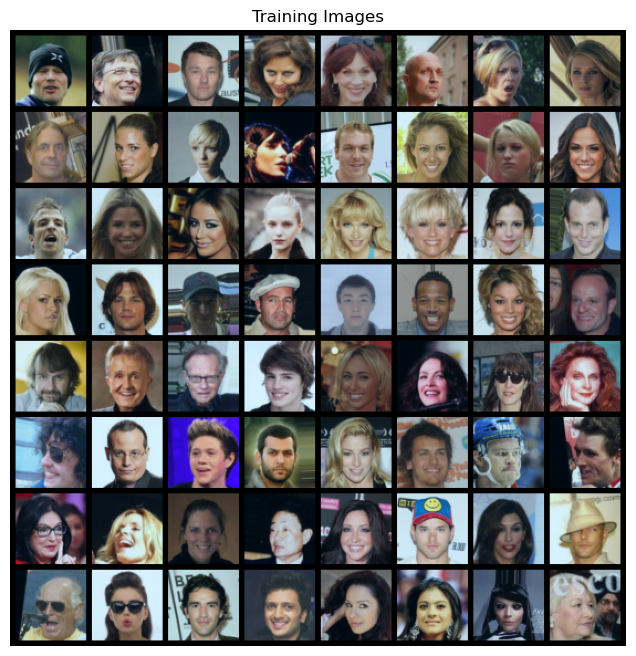

In [3]:
seed = 999  # for same results
# seed = random.randint(1, 10000) # for variation
print("Random Seed: ", seed)
random.seed(seed)
torch.manual_seed(seed)

img_size = 64
batch_size = 128
workers = 4
root = "./data/CelebA"
nz = 100
# Size of feature maps in generator
gen_features = 64
# Size of feature maps in discriminator
disc_features = 64
# Number of training epochs
num_epochs = 1
# Learning rate for optimizers

dataset = datasets.ImageFolder(
    root=root,
    transform=tf.Compose(
        [
            tf.Resize(img_size),
            tf.CenterCrop(img_size),
            tf.ToTensor(),
            tf.Normalize(
                mean=(0.50612009, 0.42543493, 0.38282761),
                std=(0.26589054, 0.24521921, 0.24127836),
            ),
        ]
    ),
)

dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=workers
)

DEVICE = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
grid_img = torchvision.utils.make_grid(real_batch[0])
plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(
            real_batch[0][:64], padding=5, normalize=True
        ).cpu(),
        (1, 2, 0),
    )
)

## Setup weight function

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generator Setup and Initialization

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # N x nz x 1 x 1
            nn.ConvTranspose2d(
                in_channels=nz,
                out_channels=gen_features * 8,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False,
            ),
            nn.BatchNorm2d(gen_features * 8),
            nn.Dropout(),
            nn.ReLU(True),
            # N x (gen_features*8) x 4 x 4
            # Paper uses kernel_size=5, stride=2 ==> cannot get 8x8 output
            nn.ConvTranspose2d(
                in_channels=gen_features * 8,
                out_channels=gen_features * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(gen_features * 4),
            # nn.Dropout(),
            nn.ReLU(True),
            # N x (gen_features*4) x 8 x 8
            nn.ConvTranspose2d(
                in_channels=gen_features * 4,
                out_channels=gen_features * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(gen_features * 2),
            # nn.Dropout(),
            nn.ReLU(True),
            # N x (gen_features*2) x 16 x 16
            nn.ConvTranspose2d(
                in_channels=gen_features * 2,
                out_channels=gen_features,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(gen_features),
            nn.ReLU(True),
            # N x gen_features x 32 x 32
            nn.ConvTranspose2d(
                in_channels=gen_features,
                out_channels=3,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.Tanh(),
            # N x 3 x 64 x 64
        )

    def forward(self, x):
        return self.gen(x)

In [6]:
# Create the generator
netG = Generator().to(DEVICE)

netG.apply(weights_init)

print(netG)

Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 

## Discriminator setup and initialization

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            # Nx3x64x64
            nn.Conv2d(
                in_channels=3,
                out_channels=disc_features,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.LeakyReLU(0.1),
            # N x disc_features x 32 x 32
            self._step(
                in_channels=disc_features,
                out_channels=disc_features * 2,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            # N x (disc_features*2) x 16 x 16
            self._step(
                in_channels=disc_features * 2,
                out_channels=disc_features * 4,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            self._step(
                in_channels=disc_features * 4,
                out_channels=disc_features * 8,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            # N x (disc_features*8) x 4 x 4
            nn.Conv2d(
                in_channels=disc_features * 8,
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=0,
            ),
            nn.Sigmoid(),
            # N x 1 x 1 x 1
        )

    def _step(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.net(x)

In [8]:
# Create the Discriminator
netD = Discriminator().to(DEVICE)

netD.apply(weights_init)

print(netD)

Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.5, inplace=False)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.5, inplace=False)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.5

## Initialize Loss and Optimizers

In [9]:
criterion = nn.BCELoss()

D_lr = 0.002
G_lr = 0.001

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=DEVICE)

real_label = 1.0
fake_label = 0.0

# Setup Adam optimizer for D and G
optimizerD = torch.optim.SGD(netD.parameters(), lr=D_lr)
optimizerG = torch.optim.SGD(netG.parameters(), lr=G_lr)


lr_schedule_D_1 = torch.optim.lr_scheduler.CyclicLR(
    optimizer=optimizerD, base_lr=1e-6, max_lr=0.1
)
lr_schedule_G_1 = torch.optim.lr_scheduler.CyclicLR(
    optimizer=optimizerG, base_lr=1e-5, max_lr=0.1
)
lr_schedule_D_2 = torch.optim.lr_scheduler.LinearLR(
    optimizer=optimizerD, start_factor=0.8, total_iters=600
)
lr_schedule_G_2 = torch.optim.lr_scheduler.LinearLR(
    optimizer=optimizerG, start_factor=0.5, total_iters=600
)

lr_schedule_D = torch.optim.lr_scheduler.ChainedScheduler(
    schedulers=[lr_schedule_D_1, lr_schedule_D_2]
)
lr_schedule_G = torch.optim.lr_scheduler.ChainedScheduler(
    schedulers=[lr_schedule_G_1, lr_schedule_G_2]
)

## Training Loop

In [10]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        netD.zero_grad()
        real_cpu = data[0].to(DEVICE)
        b_size = real_cpu.size(0)
        label = torch.full(
            (b_size,), real_label, dtype=torch.float, device=DEVICE
        )
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=DEVICE)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        lossD = errD_real + errD_fake
        optimizerD.step()
        lr_schedule_D.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        lossG = criterion(output, label)
        lossG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        lr_schedule_G.step()

        if i % 50 == 0:
            print(
                f"[{epoch+1}/{num_epochs}][{i}/{len(dataloader)}] \tLoss_D: {lossD.item():.4f} \tLoss_G: {lossG.item():.4f} \tD(x): {D_x:.4f} \tD(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}"
            )

        # save loss for plot
        G_losses.append(lossG.item())
        D_losses.append(lossD.item())

        # save G output on fixed noise
        if (iters % 500 == 0) or (
            (epoch == num_epochs - 1) and (i == len(dataloader) - 1)
        ):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(
                torchvision.utils.make_grid(fake, padding=2, normalize=True)
            )

        iters += 1

Starting Training Loop...
[1/1][0/1583] 	Loss_D: 1.8307 	Loss_G: 0.8303 	D(x): 0.6229 	D(G(z)): 0.5585/0.5469
[1/1][50/1583] 	Loss_D: 0.5400 	Loss_G: 10.5127 	D(x): 0.8209 	D(G(z)): 0.0023/0.0002
[1/1][100/1583] 	Loss_D: 1.6669 	Loss_G: 98.8283 	D(x): 0.8767 	D(G(z)): 0.0000/0.0000
[1/1][150/1583] 	Loss_D: 0.0000 	Loss_G: 66.1374 	D(x): 1.0000 	D(G(z)): 0.0000/0.0000
[1/1][200/1583] 	Loss_D: 0.0000 	Loss_G: 60.7013 	D(x): 1.0000 	D(G(z)): 0.0000/0.0000


## Visualise the loss

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

NameError: name 'plt' is not defined

## Animate the generators progression

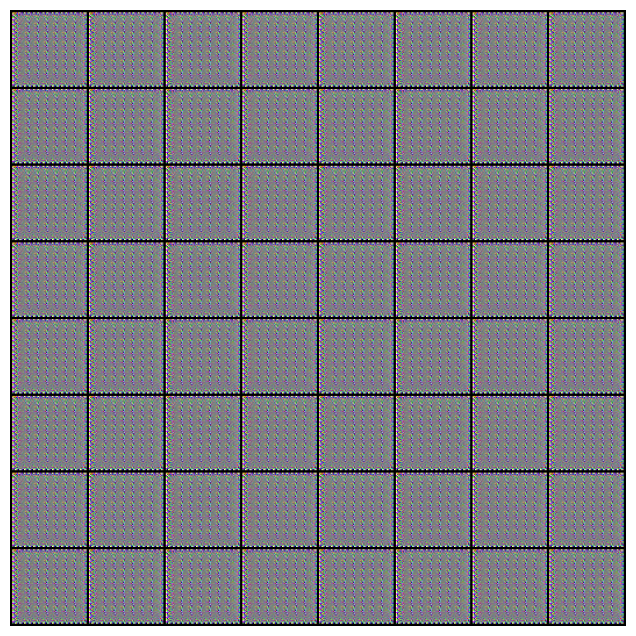

In [ ]:
from IPython.display import HTML

fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [
    [plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list
]
ani = animate.ArtistAnimation(
    fig, ims, interval=1000, repeat_delay=1000, blit=True
)

HTML(ani.to_jshtml())